###### Bibliotécas

In [1]:
import datetime
import math
import random
import pickle
import warnings
import inflection
import random
import requests

import numpy    as np
import pandas   as pd
import seaborn  as sns
import sweetviz as sv
import xgboost  as xgb

from boruta                import BorutaPy
from matplotlib            import gridspec
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from matplotlib.gridspec   import GridSpec
from tabulate import tabulate

from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn                 import datasets as dt
from sklearn.metrics         import make_scorer, mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

### Funções

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi_quadrado = ss.chi2_contingency(cm)[0]
    chi_quadrado_correcao = max(0, chi_quadrado - (k - 1) * (r -1) / (n -1))
    k_correcao = k - (k - 1) ** 2 / (n - 1)
    r_correcao = r - (r - 1) ** 2 / (n - 1)
    
    v = np.sqrt((chi_quadrado_correcao / n) / (min(k_correcao - 1, r_correcao -1)))
    return v

def mean_percentage_error(y, y_pred):
    return np.mean((y - y_pred) / y)

def mean_absolute_percentage_error(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y))

def ml_error(model_name, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    return pd.DataFrame({'nome_algoritmo': model_name,
                         'mae': mae,
                         'mape': mape,
                         'rmse': rmse}, index = [0])

def cross_validation(x_treinamento, kfold, model_name, model, verbose = False):
    #Inicio e final da data para validação. Lembrando que os dados para teste já foram separados
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKfold number: {}'.format(k))
        validation_start_date = x_treinamento['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_treinamento['date'].max() - datetime.timedelta(days = (k - 1) * 6 * 7)
        
        #Filtrando o dataset
        treinamento = x_treinamento[x_treinamento['date'] < validation_start_date]
        validacao = x_treinamento[(x_treinamento['date'] >= validation_start_date) & (x_treinamento['date'] <= validation_end_date)]
        
        #Treinamento e validação do dataset
        #Treinamento
        xtreinamento = treinamento.drop(['date', 'sales'], axis = 1)
        ytreinamento = treinamento['sales']
        #Validação
        xvalidacao = validacao.drop(['date', 'sales'], axis = 1)
        yvalidacao = validacao['sales']
        
        #Treinando o modelo
        modelo = model.fit(xtreinamento, ytreinamento)
        #Predição
        y_pred = modelo.predict(xvalidacao)
        
        #Performance
        resultado = ml_error(model_name, np.expm1(yvalidacao), np.expm1(y_pred))
        
        mae_list.append(resultado['mae'])
        mape_list.append(resultado['mape'])
        rmse_list.append(resultado['rmse'])
    
    return pd.DataFrame({'algoritmo': model_name,
                         'mae_cv': np.round(np.mean(mae_list),2).astype(str) + ' +/-' + np.round(np.std(mae_list), 2).astype(str),
                         'mape_cv': np.round(np.mean(mape_list),2).astype(str) + ' +/-' + np.round(np.std(mape_list), 2).astype(str),
                         'rmse_cv': np.round(np.mean(rmse_list),2).astype(str) + ' +/-' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

### Carregando os dados

In [3]:
df_sales_raw = pd.read_csv('../dataset/train.csv', low_memory = False)
df_store_raw = pd.read_csv('../dataset/store.csv', low_memory = False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados 

In [4]:
df1 = df_raw.copy()

### 1.1 Renomear as colunas

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Dimensão dos dados

In [8]:
print('Nº de linhas: {}'.format(df1.shape[0]))
print('Nº de colunas: {}'.format(df1.shape[1]))

Nº de linhas: 1017209
Nº de colunas: 18


### 1.3 Tipo de dados

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Verificar NA's

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Preenchendo os NA's

In [12]:
#Colunas que contém NA's

#competition_distance              2642
#competition_open_since_month    323348
#competition_open_since_year     323348
#promo2                               0
#promo2_since_week               508031
#promo2_since_year               508031
#promo_interval                  508031

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
#Preenchendo as colunas com NA's
#competition_distance
#Inserindo um valor muito maior que o máximo valor da coluna 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

In [15]:
df1['competition_distance'].max()

200000.0

In [16]:
#competition_open_since_month
#Como não tem data, está sendo assumido o valor da coluna data para preencher este campo
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [17]:
df1.sample(5).T

,849553,652776,327708,371291,11861
store,709,172,762,329,712
day_of_week,5,6,4,6,2
date,2013-05-31 00:00:00,2013-11-23 00:00:00,2014-09-25 00:00:00,2014-08-09 00:00:00,2015-07-21 00:00:00
sales,12600,6252,2777,3881,5236
customers,1558,844,352,383,522
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,d,a,a


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Verificando os tipos novamente devido a alteração das colunas com NA's

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
#Verificando os tipos novamente devido a alteração das colunas com NA's
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descrição estatística do negócio

In [22]:
#Separando as colunas com variáveis numéricas e variáveis categóricas
num_atributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

#### Métricas de tendência central (média e mediana)
#### Métricas de dispersão (desvio padrão, min, máx, amplitude, assimetria, curtose)

#### 1.7.1 Atributos numéricos 

In [23]:
ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

d1 = pd.DataFrame(num_atributes.apply(np.std)).T
d2 = pd.DataFrame(num_atributes.apply(min)).T
d3 = pd.DataFrame(num_atributes.apply(max)).T
d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T

metricas = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metricas.columns = ['atributes', 'min', 'max', 'amplitude', 'mean', 'median', 'std', 'assimetrica', 'kurtosis']
metricas

,atributes,min,max,amplitude,mean,median,std,assimetrica,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


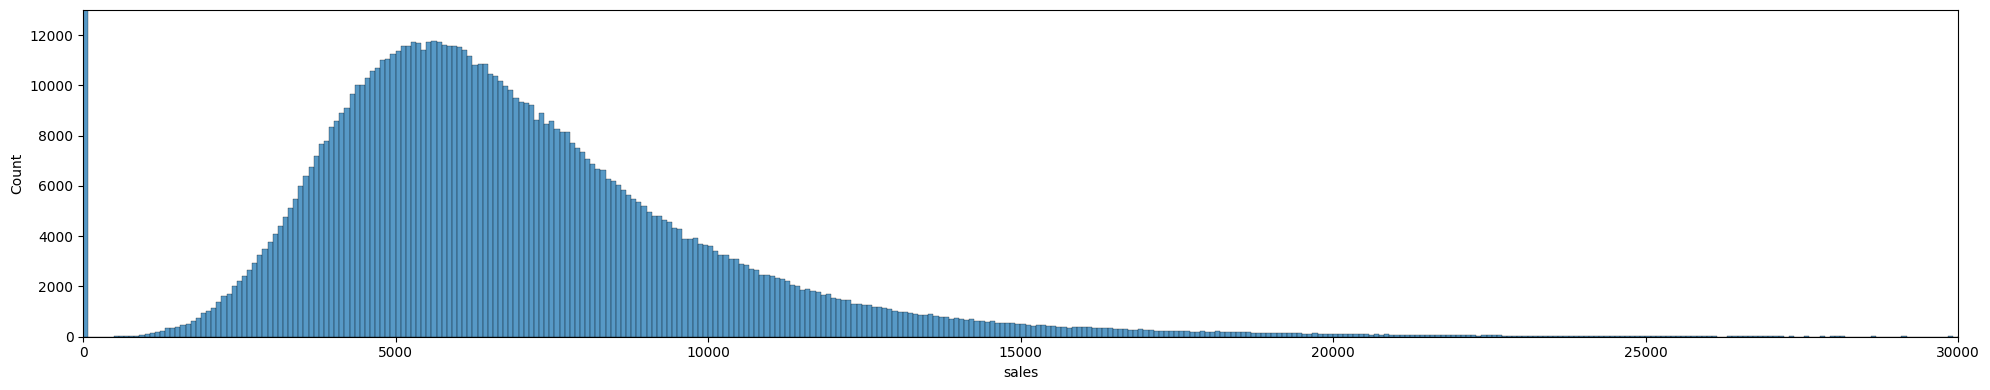

In [24]:
plt.figure(figsize=(20, 4))
ax = sns.histplot(x = 'sales', data = df1)

ax.set(xlim = (0, 30000), ylim = (0, 13000))
plt.tight_layout();
plt.show;

#### 1.7.2 Atributos categóricos

In [25]:
#Encontrando a qtdes de tipos de categorias existem em cada coluna
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

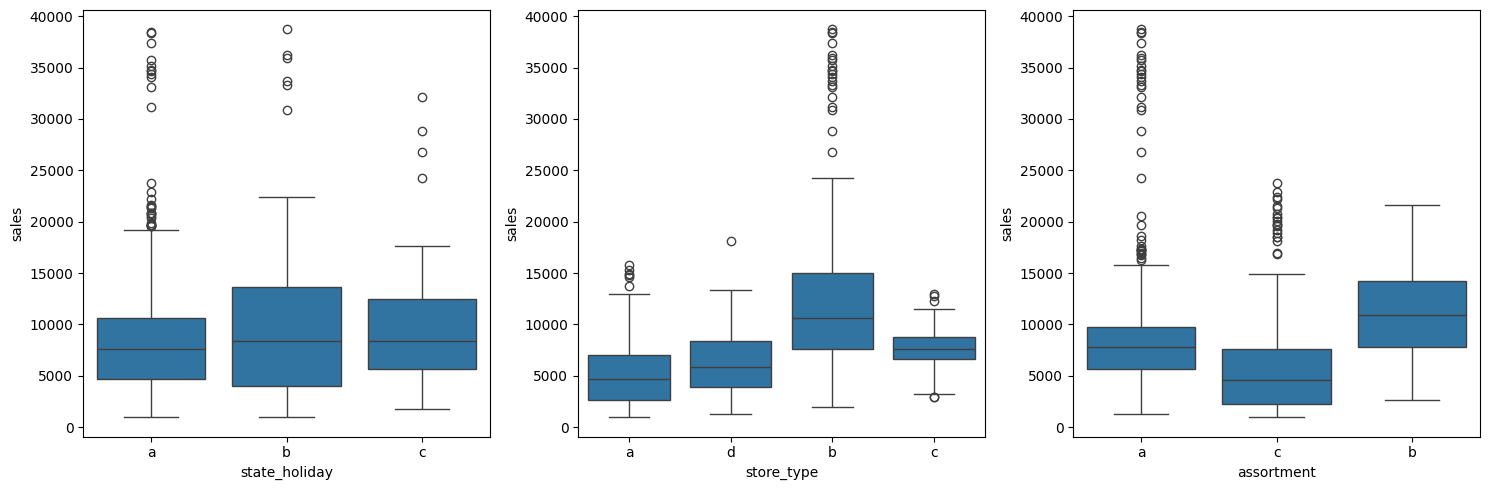

In [26]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#Criando uma figura maior
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

#plt.subplots_adjust(wspace = 0.5) #Ajusta o espaçamento horizontal entre os gráficos
plt.tight_layout();
plt.show;

# 2. (Limpeza dos dados) Passo 2: Engenharia de atributos (mapa mental) 

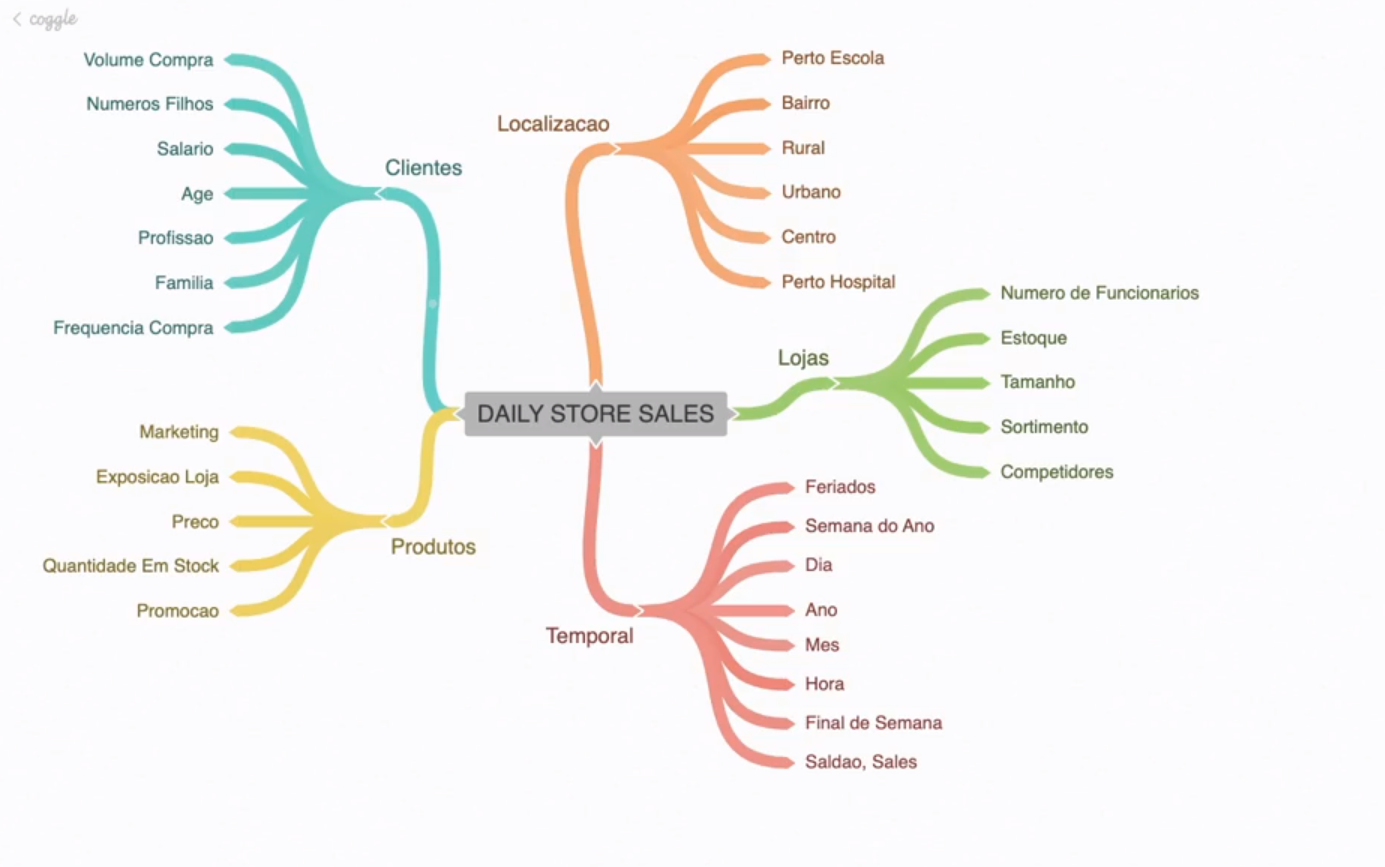

In [27]:
Image('../img/Mapa_mental.PNG')

In [28]:
df2 = df1.copy()

### 2.1 Mapa mental de hipóteses

##### Criação de hipóteses

##### Hipótese Loja
**1** Lojas com maior quadro de funcionários deveriam vender mais

**2** Lojas com maior capacidade de estoque deveriam vender mais

**3** Lojas com maior porte deveriam vender mais

**4** Lojas com maior sortimento (variedade) deveriam vender mais

**5** Lojas com competidores mais próximos deveriam vender menos

**6** Lojas com competidores à mais tempo deveriam vender mais

##### Hipótese Produto
**1** Lojas que investem mais em marketing deveriam vender mais

**2** Lojas com maior exposição de produto de deveriam vender mais

**3** Lojas com preços menores nos produtos deveriam vender mais

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5** Lojas com promoções ativas por mais tempo deveriam vender mais

**6** Lojas com mais dias de promoção deveriam vender mais

**7** Lojas com mais promoções consecutivas deveriam vender mais

##### Hipótese Tempo
**1** Lojas abertas durante o feriado de Natal deveriam vender mais

**2** Lojas deveriam vender mais ao longo dos anos

**3** Lojas deveriam vender mais no segundo sementre do ano

**4** Lojas deveriam vender mais depois do dia 10 de cada mês

**5** Lojas deveriam vender menos aos finais de semana

**6** Lojas deveriam vender menos durante feriados escolares

### 2.2 Priorizando as hipóteses

In [29]:
#Das hipóteses listadas, quais já são possiveis validar ou refutar com os dados disponives no dataset atual?

##### Hipótese Loja
**1** Lojas com maior sortimento (variedade) deveriam vender mais
    
**2** Lojas com competidores mais próximos deveriam vender menos

**3** Lojas com competidores à mais tempo deveriam vender mais

##### Hipótese Produto
**4** Lojas com promoções ativas por mais tempo deveriam vender mais

**5** Lojas com mais dias de promoção deveriam vender mais

**6** Lojas com mais promoções consecutivas deveriam vender mais

##### Hipótese Tempo
**7** Lojas abertas durante o feriado de Natal deveriam vender mais

**8** Lojas deveriam vender mais ao longo dos anos

**9** Lojas deveriam vender mais no segundo sementre do ano

**10** Lojas deveriam vender mais depois do dia 10 de cada mês

**11** Lojas deveriam vender menos aos finais de semana

**12** Lojas deveriam vender menos durante feriados escolares

### 2.3 Exploração das hipóteses listadas

#### 2.3.1 Derivando as variáveis a partir das variáveis originais

In [30]:
#Derivando as variáveis a partir das variáveis originais
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int) 

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int) 

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [31]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio) 

In [32]:
df3 = df2.copy()

### 3.1 Filtragem das linhas

In [33]:
#Na coluna 'open', para a predição é necessário as lojas estejam abertas para prever a qtde de vendas nas próximas 6 semanas
#'open' != 0
#Outra restrição do negócio
#'sales' > 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2 Seleção das colunas

In [34]:
#Na coluna 'customers', não tenho como saber quantos clientes terão daqui 6 semanas então se torna uma restrição do negócio
#'customers'
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados 

In [35]:
df4 = df3.copy()

### 4.1 Análise univariada

##### Variável resposta

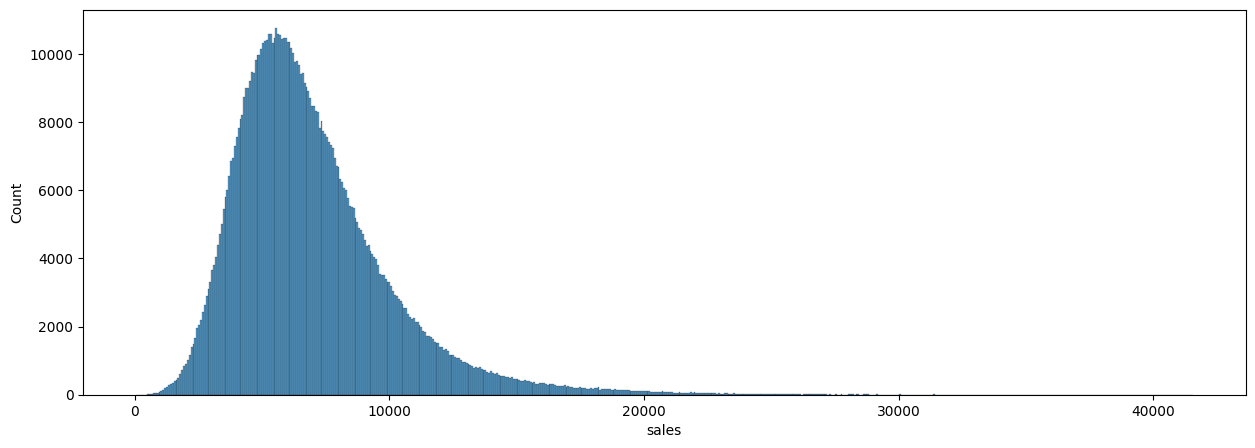

In [36]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário
sns.histplot(df4['sales']);

##### 4.1.1 Variável numérica

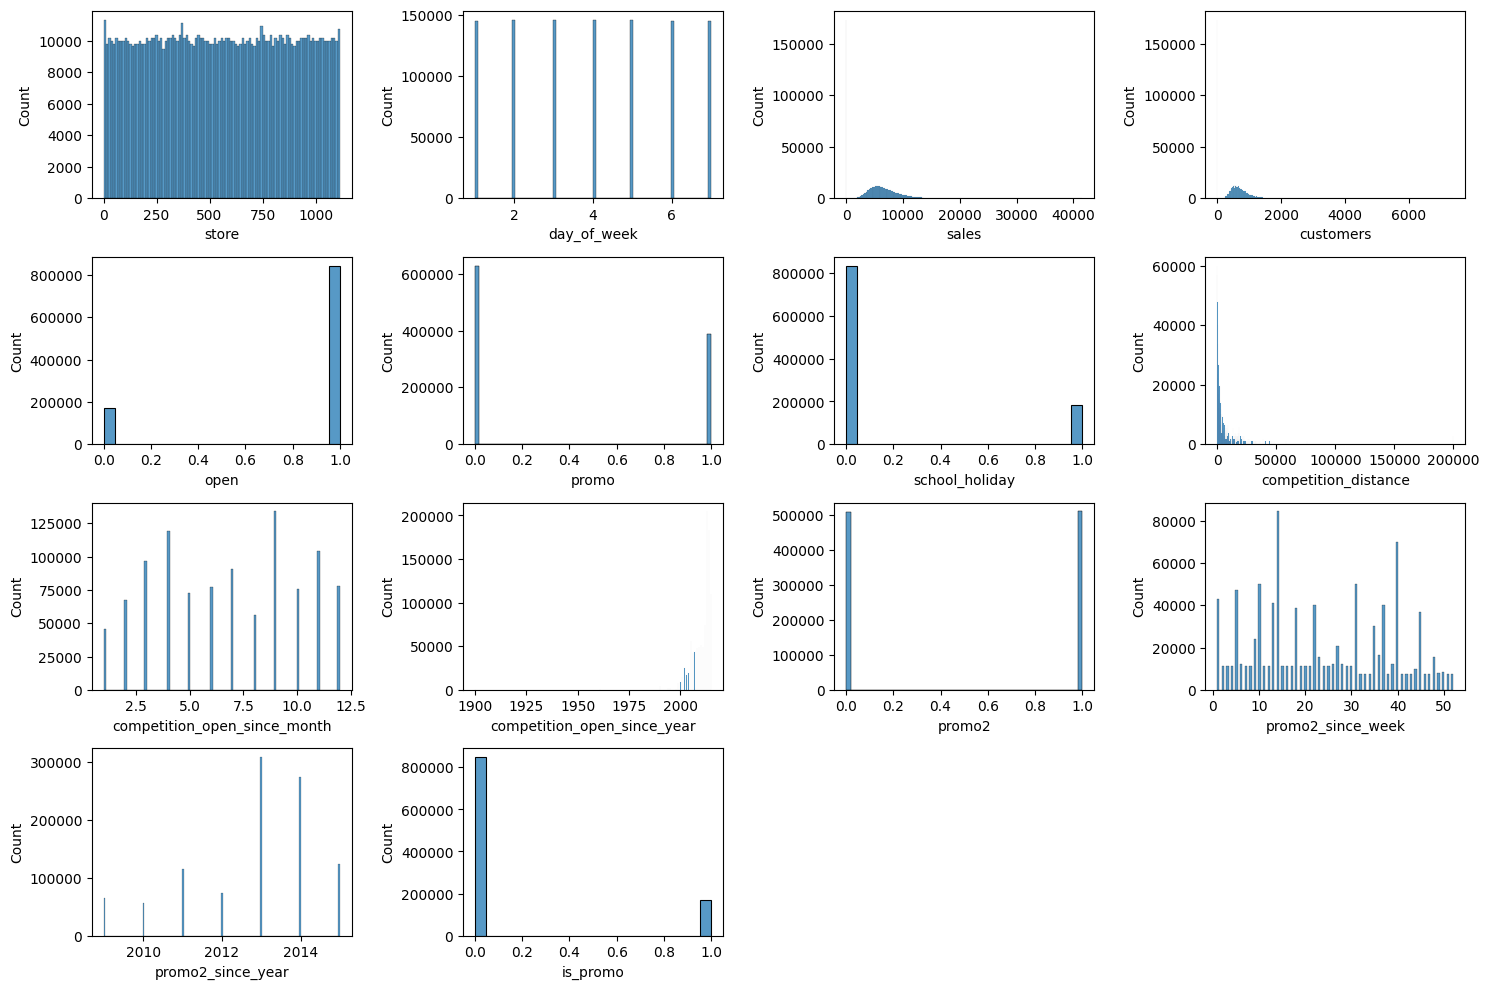

In [37]:
plt.figure(figsize = (15, 10)) #Ajuste o tamanho conforme necessário

#store
plt.subplot(4, 4, 1)
sns.histplot(x = 'store', data = num_atributes)

#day_of_week
plt.subplot(4, 4, 2)
sns.histplot(x = 'day_of_week', data = num_atributes)

#sales
plt.subplot(4, 4, 3)
sns.histplot(x = 'sales', data = num_atributes)

#customers
plt.subplot(4, 4, 4)
sns.histplot(x = 'customers', data = num_atributes)

#open
plt.subplot(4, 4, 5)
sns.histplot(x = 'open', data = num_atributes)

#promo
plt.subplot(4, 4, 6)
sns.histplot(x = 'promo', data = num_atributes)

#school_holiday
plt.subplot(4, 4, 7)
sns.histplot(x = 'school_holiday', data = num_atributes)

#competition_distance
plt.subplot(4, 4, 8)
sns.histplot(x = 'competition_distance', data = num_atributes)

#competition_open_since_month
plt.subplot(4, 4, 9)
sns.histplot(x = 'competition_open_since_month', data = num_atributes)

#competition_open_since_year
plt.subplot(4, 4, 10)
sns.histplot(x = 'competition_open_since_year', data = num_atributes)

#promo2
plt.subplot(4, 4, 11)
sns.histplot(x = 'promo2', data = num_atributes)

#promo2_since_week
plt.subplot(4, 4, 12)
sns.histplot(x = 'promo2_since_week', data = num_atributes)

#promo2_since_year
plt.subplot(4, 4, 13)
sns.histplot(x = 'promo2_since_year', data = num_atributes)

#is_promo
plt.subplot(4, 4, 14)
sns.histplot(x = 'is_promo', data = num_atributes)

plt.tight_layout();

##### 4.1.2 Variável categórica

In [38]:
cat_atributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [39]:
df4['state_holiday'].drop_duplicates() #Retorna as categorias únicas da coluna 'state_holiday' do dataframe original

0            regular_day
63559     public holiday
129424    easter holiday
241126         christmas
Name: state_holiday, dtype: object

In [40]:
df4['store_type'].drop_duplicates() #Retorna as categorias únicas da coluna 'store_type' do dataframe original

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [41]:
df4['assortment'].drop_duplicates() #Retorna as categorias únicas da coluna 'assortment' do dataframe original

0         basic
3      extended
258       extra
Name: assortment, dtype: object

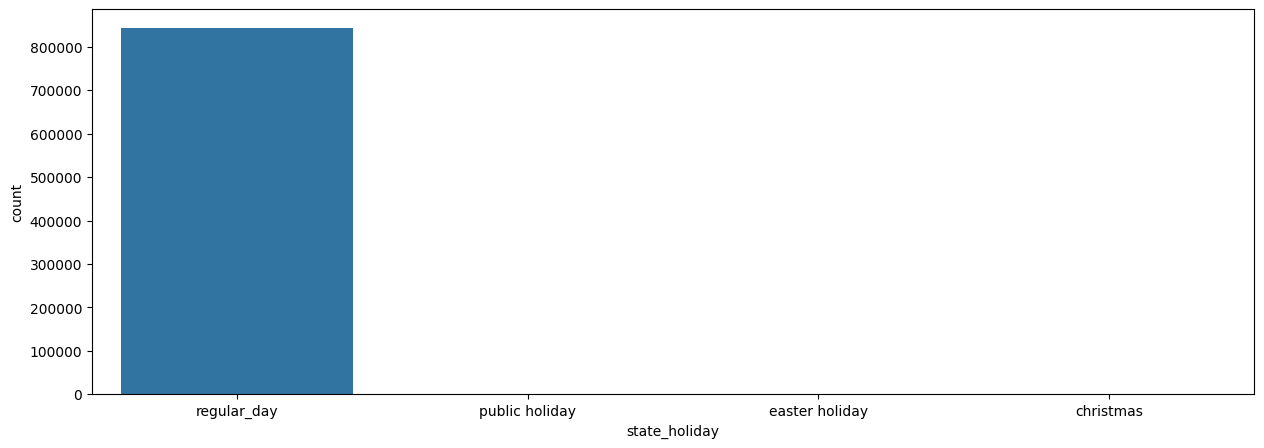

In [42]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

#state_holiday
sns.countplot(x = 'state_holiday', data = df4);
#Como o regular_day é muito maior que os outros dias, não aparecem as outras categorias

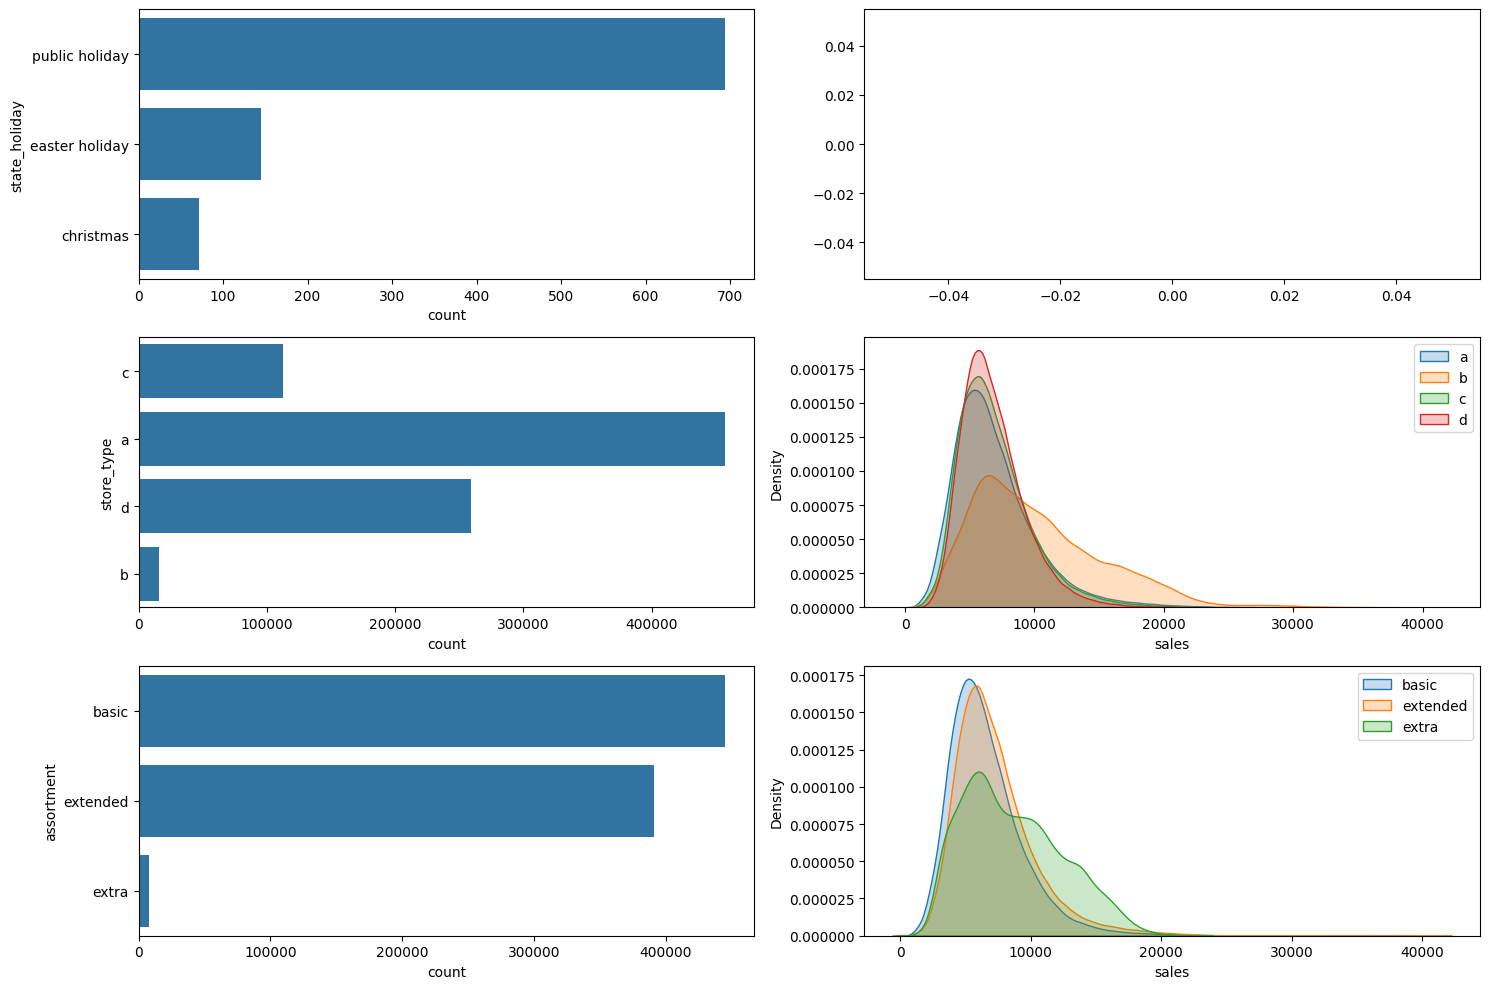

In [43]:
plt.figure(figsize = (15, 10)) #Ajuste o tamanho conforme necessário

#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label = 'christmas_holiday', fill = True)
#plt.legend()
plt.tight_layout();

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True)
plt.legend()
plt.tight_layout();

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True)
plt.legend()
plt.tight_layout();

### 4.2 Análise bivariada

In [44]:
#Avalia a variável resposta com as demais variáveis

##### Hipótese Loja
**1** Lojas com maior sortimento (variedade) deveriam vender mais

**Falsa** Baseando-se nos dados, lojas com maior sortimento (variedade) vendem menos

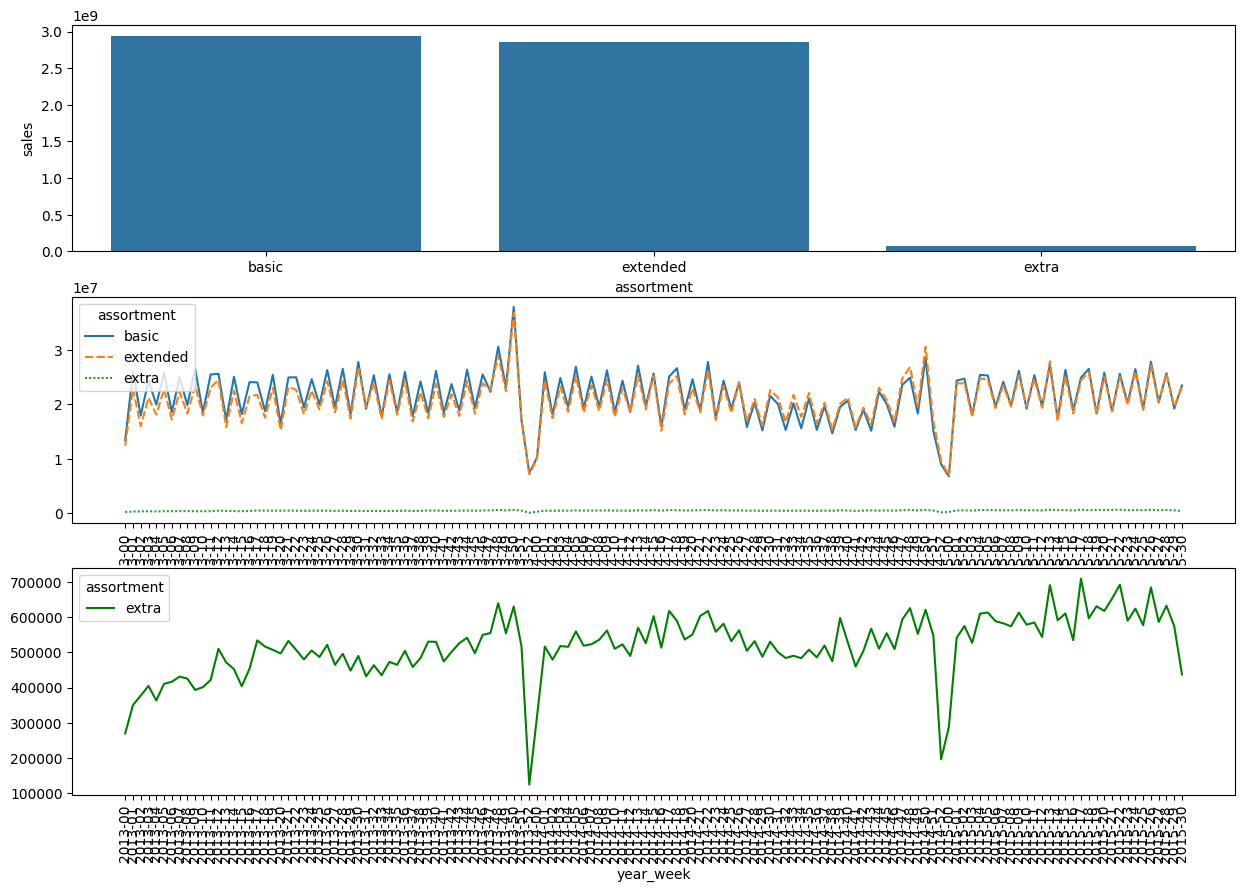

In [45]:
plt.figure(figsize = (15, 10)) #Ajuste o tamanho conforme necessário

#grid = GridSpec(2, 2) #Concatena os gráficos

#Avaliando os tipos de assortment com as vendas
#plt.subplot(grid[0, :])
plt.subplot(3, 1, 1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

#plt.subplot(grid[1, 0])
plt.subplot(3, 1, 2)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
plt.xticks(rotation = 90)
sns.lineplot(aux3);

#Como o comportamento do assortment = extra é muito baixo, é interessnate verificar se as vendas são parecidas
#com uma linha mesmo
#plt.subplot(grid[1, 1])
plt.subplot(3, 1, 3)
aux3 = aux2[aux2['assortment'] == 'extra']
aux4 = aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales')
plt.xticks(rotation = 90)
sns.lineplot(aux4, palette = ['g']);

##### Hipótese Loja    
**2** Lojas com competidores mais próximos deveriam vender menos

**Falsa** Baseando-se nos dados, lojas com competidores mais próximos vendem mais

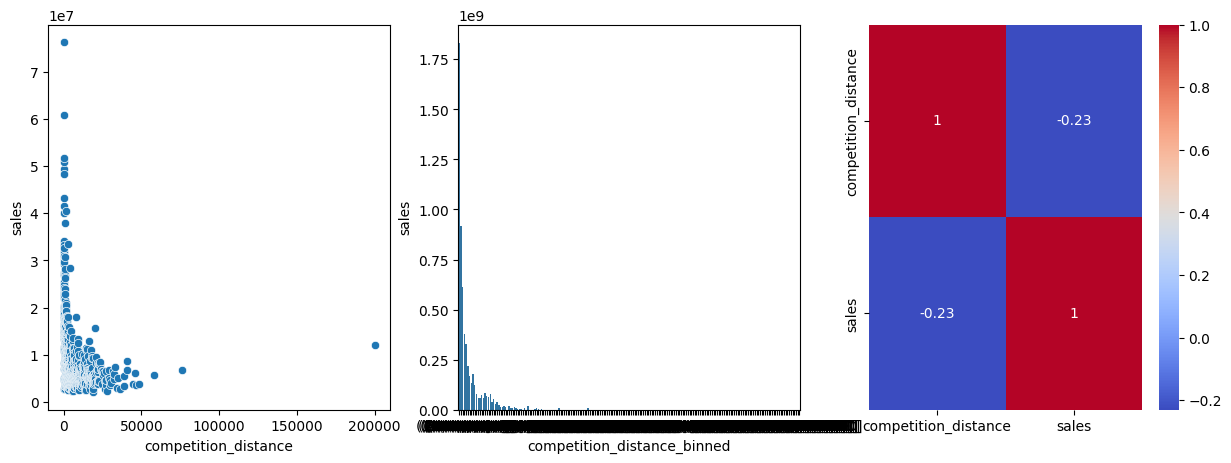

In [46]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

#Avaliando as distancias do competition distance com as vendas
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
#Como no gráfico gerado a informação do eixo x ficou muito grande, é melhor criar grupos de distância
#para reduzir os nº do eixo x 
bins = list(np.arange(0, 200000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
numeric_columns = aux1.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.show()

In [47]:
aux1.sample(6)

,competition_distance,sales,competition_distance_binned
535,14300.0,11436524,"(14000, 15000]"
69,710.0,19495195,"(0, 1000]"
284,3620.0,6952773,"(3000, 4000]"
536,14570.0,2873358,"(14000, 15000]"
70,720.0,26997194,"(0, 1000]"
229,2810.0,5648895,"(2000, 3000]"


##### Hipótese Loja
**3** Lojas com competidores à mais tempo deveriam vender mais

**Falsa** Baseando-se nos dados, lojas com à mais tempo vendem menos

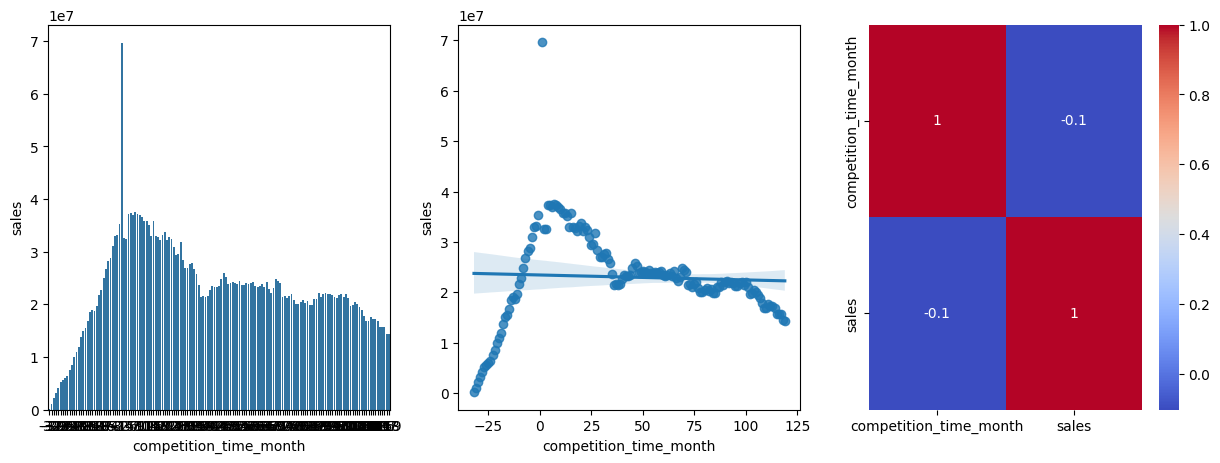

In [48]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

#Avaliando o tempo do competition time month com as vendas
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
correlation_matrix = aux1.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.show()

##### Hipótese Produto
**4** Lojas com promoções ativas por mais tempo deveriam vender mais

**Falsa** Baseando-se nos dados, lojas com promoções ativas por mais tempo vendem menos depois de um certo período

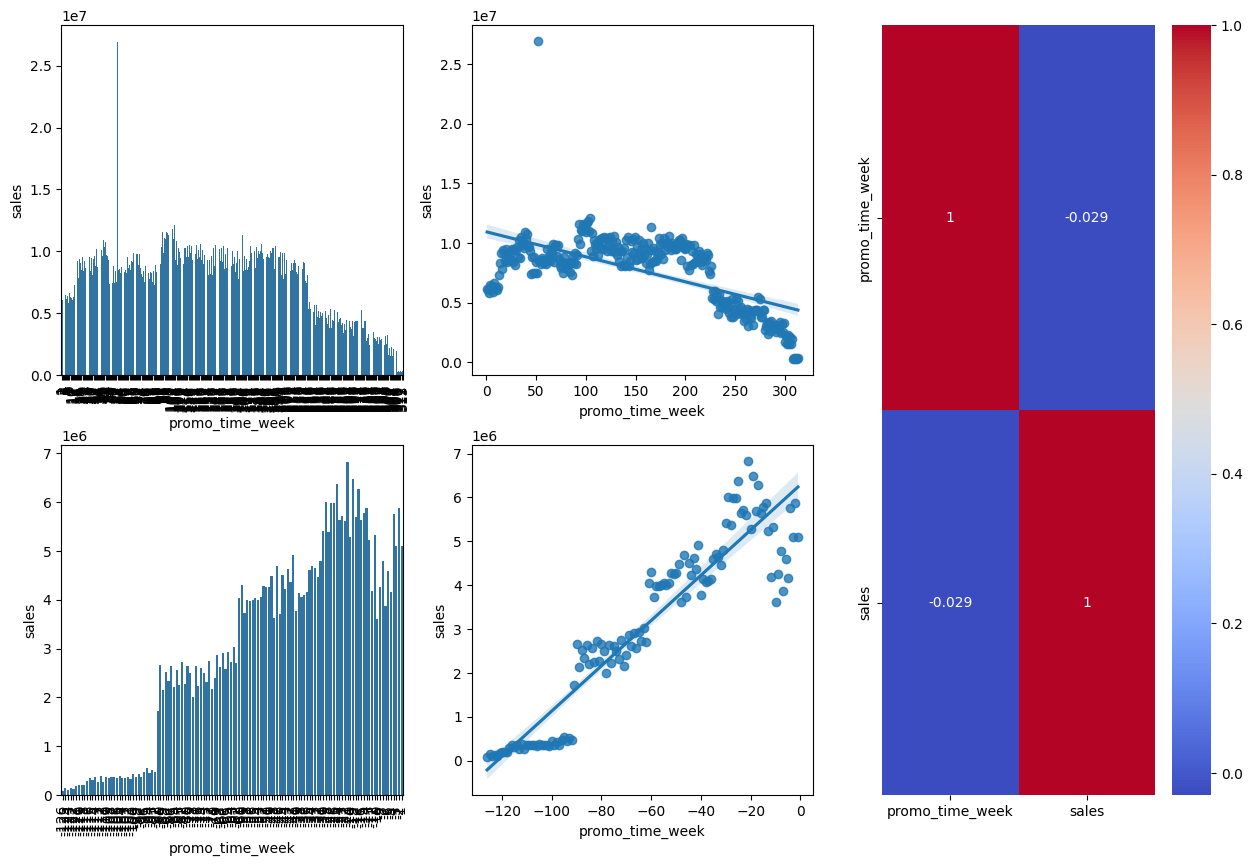

In [49]:
plt.figure(figsize = (15, 10)) #Ajuste o tamanho conforme necessário

grid = GridSpec(2, 3) #Concatena os gráficos

#Avaliando o tempo do promo time week com as vendas
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo com período extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo com período regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90)

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[:, 2])
correlation_matrix = aux1.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.show();

##### Hipótese Produto
<s>**5** Lojas com mais dias de promoção deveriam vender mais</s>

##### Hipótese Produto
**6** Lojas com mais promoções consecutivas deveriam vender mais

**Falsa** Baseando-se nos dados, lojas com mais promoções consecutivas vendem  menos

In [50]:
#Avaliando o tempo do promo com as vendas
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by = 'sales', ascending = True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


<Figure size 1500x500 with 0 Axes>

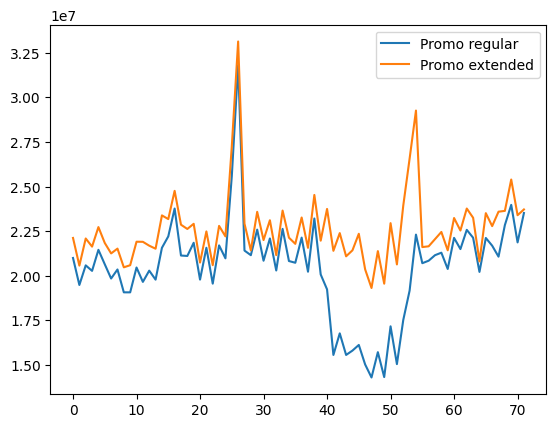

In [51]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend(labels = ['Promo regular', 'Promo extended']);
#sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
#plt.xticks(rotation = 90)

##### Hipótese Tempo
**7** Lojas abertas durante o feriado de Natal deveriam vender mais

**Falsa** Baseando-se nos dados, lojas abertas durante o feriado de Natal vendem  menos

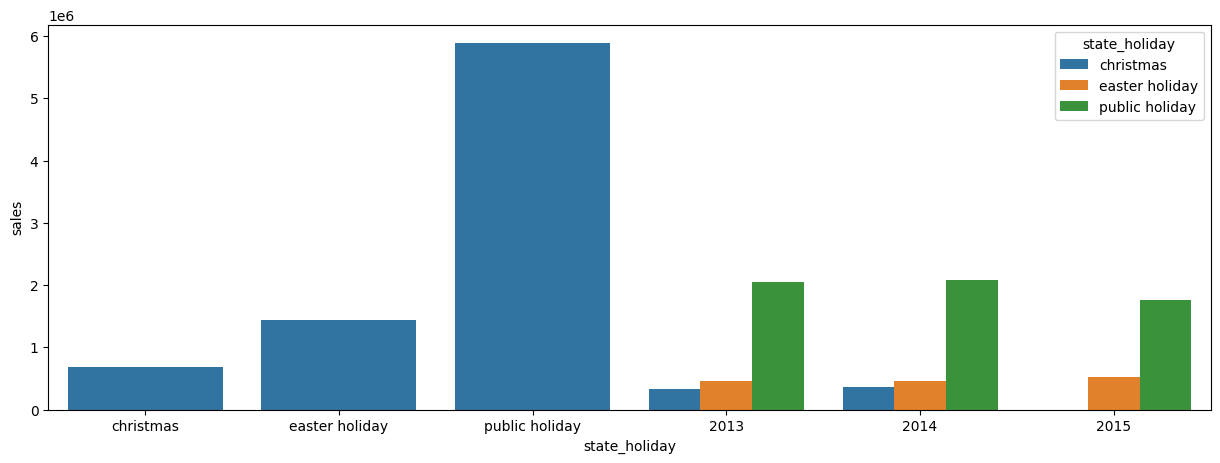

In [52]:
plt.figure(figsize = (15, 5))

#Avaliando o feriado do Natal e as vendas
plt.plot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.plot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

##### Hipótese Tempo
**8** Lojas deveriam vender mais ao longo dos anos

**Falsa** Baseando-se nos dados, lojas vendem menos ao longo dos anos

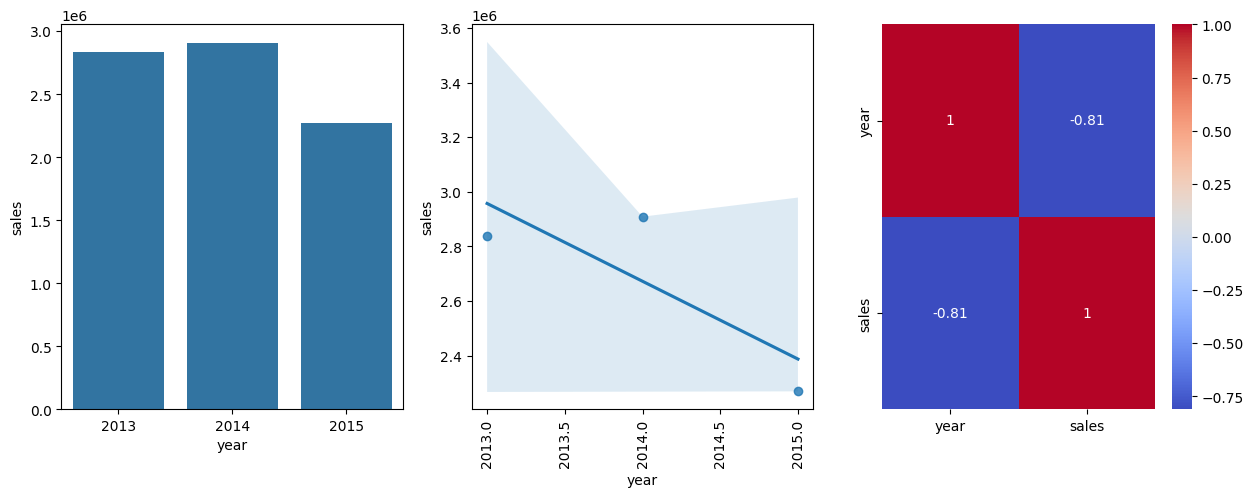

In [53]:
plt.figure(figsize = (15, 5))

#Avaliando o ano e as vendas
plt.subplot(1, 3, 1)
aux1 = aux[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
correlation_matrix = aux1.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.show()

##### Hipótese Tempo
**9** Lojas deveriam vender mais no segundo sementre do ano

**Falsa** Baseando-se nos dados, lojas vendem menos no segundo semestre do ano

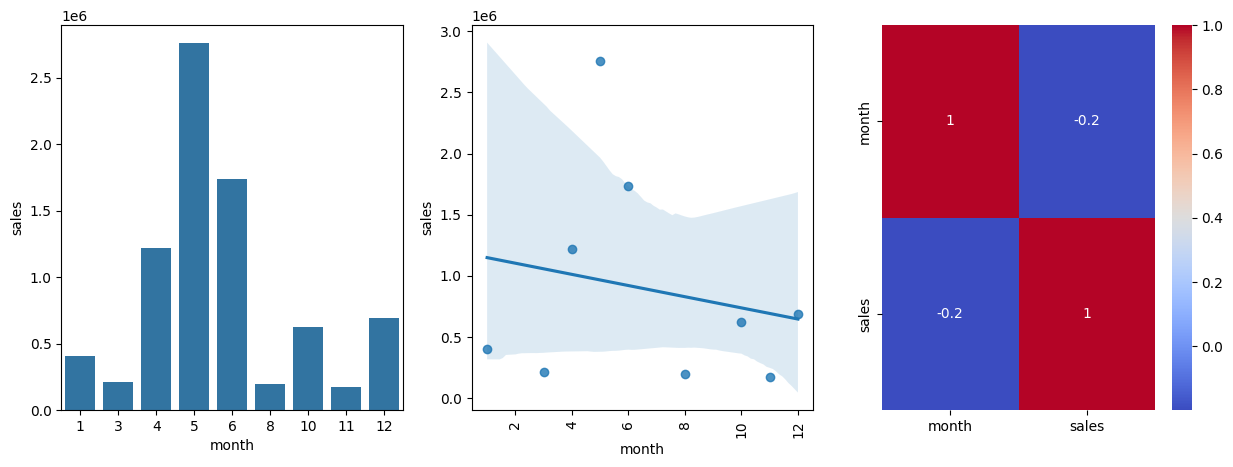

In [54]:
plt.figure(figsize = (15, 5))

#Avaliando o ano e as vendas
plt.subplot(1, 3, 1)
aux1 = aux[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
correlation_matrix = aux1.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.show()

##### Hipótese Tempo
**10** Lojas deveriam vender mais depois do dia 10 de cada mês

**Verdadeira** Baseando-se nos dados, lojas vendem mais depois do dia 10 de cada mês

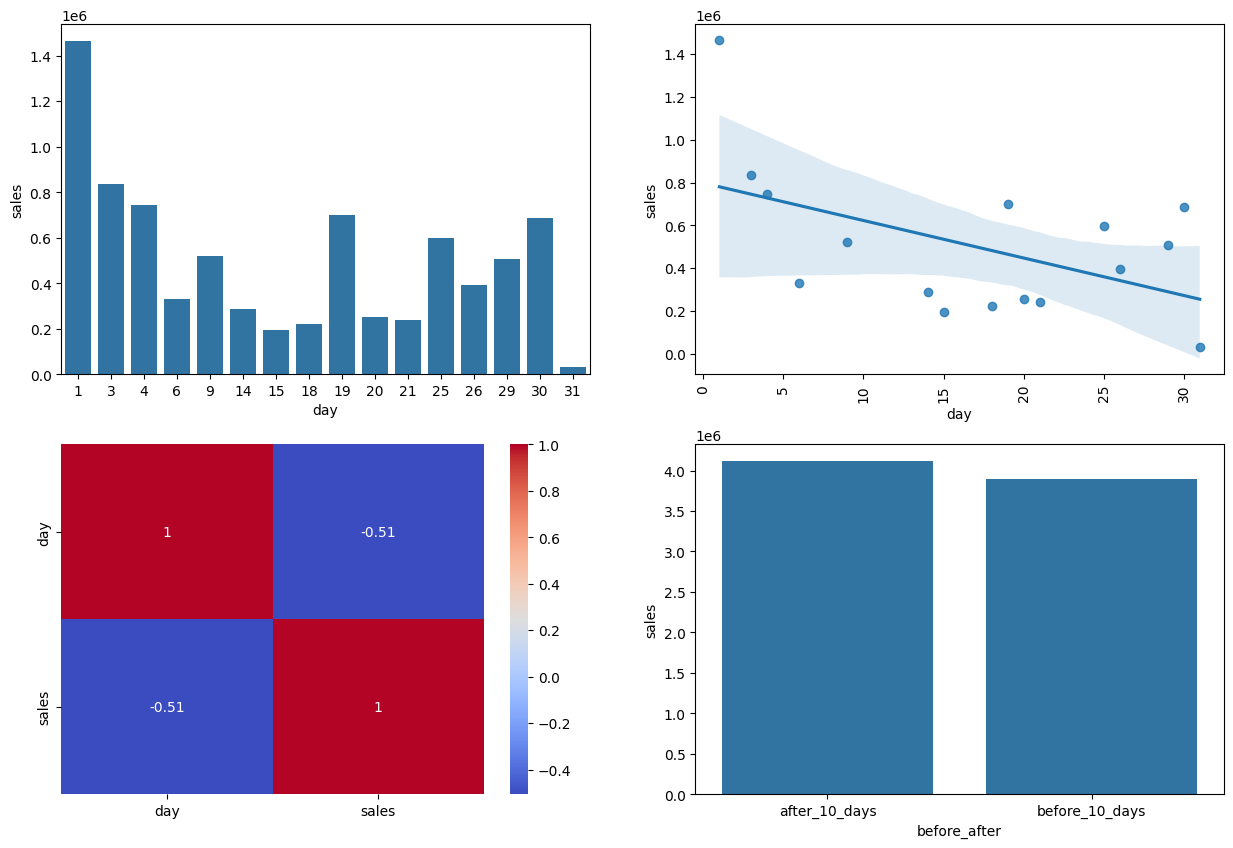

In [55]:
plt.figure(figsize = (15, 10))

#Avaliando o ano e as vendas
plt.subplot(2, 2, 1)
aux1 = aux[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)
plt.xticks(rotation = 90)

plt.subplot(2, 2, 3)
correlation_matrix = aux1.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

##### Hipótese Tempo
**11** Lojas deveriam vender menos aos finais de semana

**Verdadeira** Baseando-se nos dados, lojas vendem menos aos finais de semana

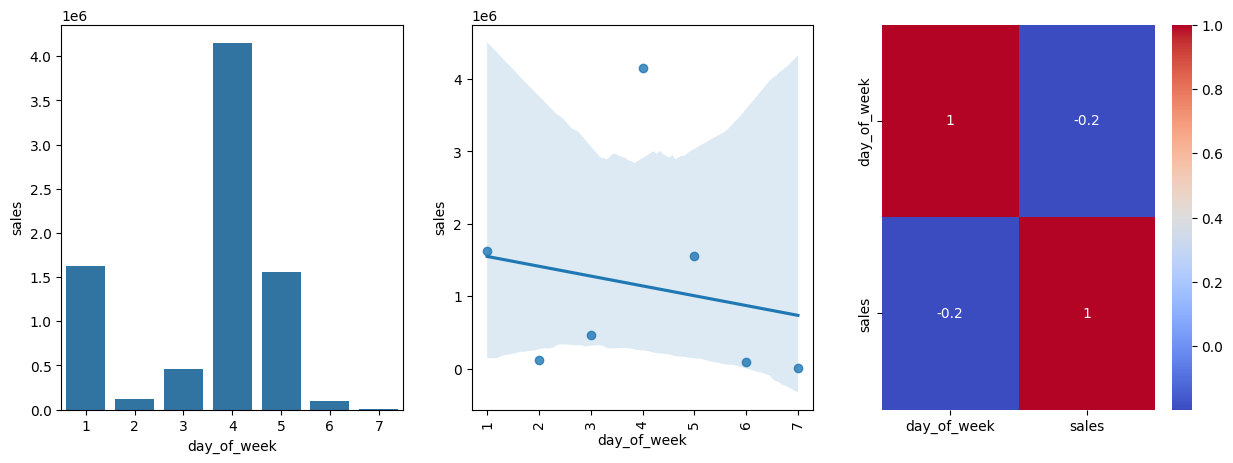

In [56]:
plt.figure(figsize = (15, 5))

#Avaliando o ano e as vendas
plt.subplot(1, 3, 1)
aux1 = aux[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
correlation_matrix = aux1.corr(method = 'pearson')
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")

plt.show()

##### Hipótese Tempo
**12** Lojas deveriam vender menos durante feriados escolares

**Verdadeira** Baseando-se nos dados, lojas vendem menos durante feriados escolares, exceto julho e agosto

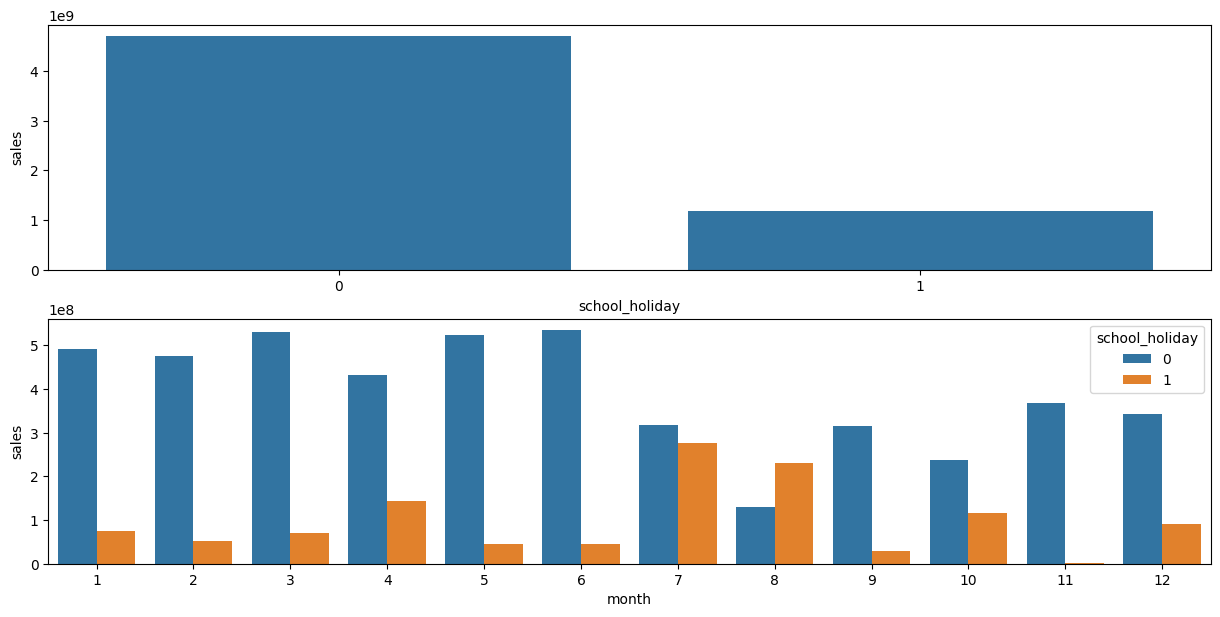

In [57]:
plt.figure(figsize = (15, 7))

#Avaliando os finais de semana e as vendas
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales',hue = 'school_holiday', data = aux2);

### 4.2.1 Resumo das hipóteses

In [58]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['Hip_1', 'Falsa', 'Baixa'],
      ['Hip_2', 'Falsa', 'Media'],
      ['Hip_3', 'Falsa', 'Media'],
      ['Hip_4', 'Falsa', 'Baixa'],
      ['Hip_5', '-', '-'],
      ['Hip_6', 'Falsa', 'Baixa'],
      ['Hip_7', 'Falsa', 'Media'],
      ['Hip_8', 'Falsa', 'Alta'],
      ['Hip_9', 'Falsa', 'Alta'],
      ['Hip_10', 'Verdadeira', 'Alta'],
      ['Hip_11', 'Verdadeira', 'Alta'],
      ['Hip_12', 'Verdadeira', 'Baixa']]
print(tabulate(tab, headers = 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
Hip_1        Falsa        Baixa
Hip_2        Falsa        Media
Hip_3        Falsa        Media
Hip_4        Falsa        Baixa
Hip_5        -            -
Hip_6        Falsa        Baixa
Hip_7        Falsa        Media
Hip_8        Falsa        Alta
Hip_9        Falsa        Alta
Hip_10       Verdadeira   Alta
Hip_11       Verdadeira   Alta
Hip_12       Verdadeira   Baixa


### 4.3 Análise multivariada

##### 4.3.1 Atributos numéricos

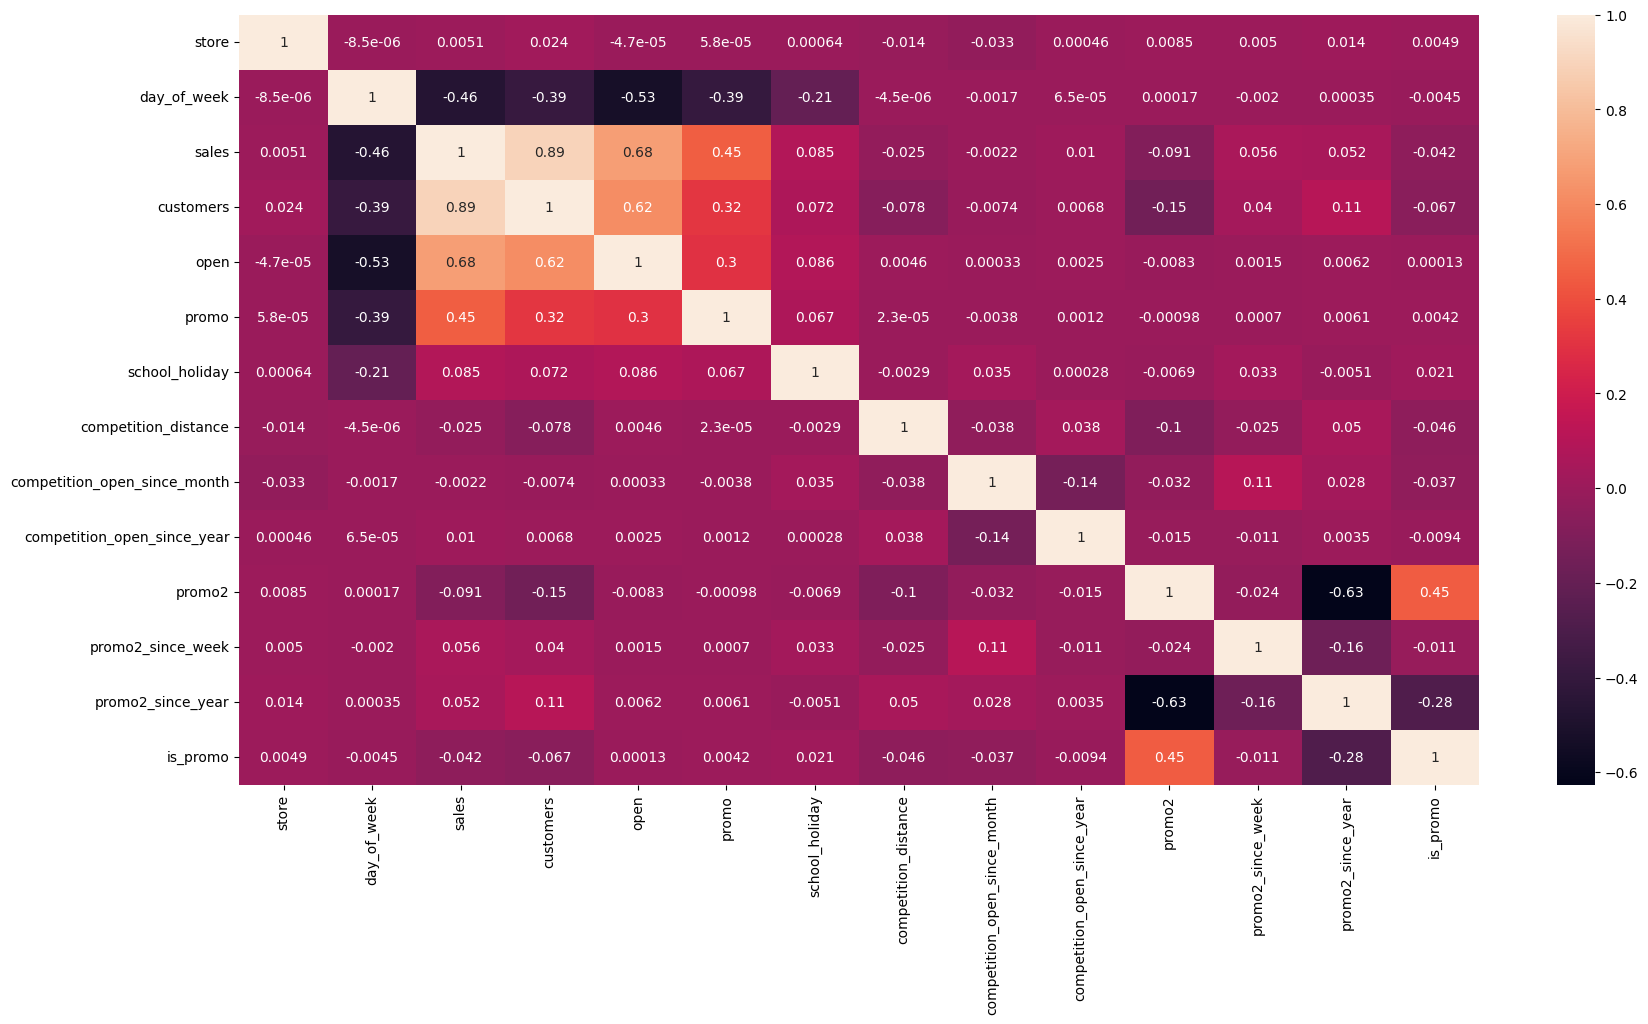

In [59]:
plt.figure(figsize = (20, 10))
correlation = num_atributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

##### 4.3.2 Atributos categóricos

In [60]:
a = df4.select_dtypes(include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [61]:
pd.crosstab(a['state_holiday'], a['store_type'])

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter holiday,36,100,0,9
public holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [62]:
a[(a['state_holiday'] =='christmas') & (a['store_type'] == 'a')] #conferindo o resultado da tabela acima

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [63]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi_quadrado = ss.chi2_contingency(cm)[0]
    chi_quadrado_correcao = max(0, chi_quadrado - (k - 1) * (r -1) / (n -1))
    k_correcao = k - (k - 1) ** 2 / (n - 1)
    r_correcao = r - (r - 1) ** 2 / (n - 1)
    
    v = np.sqrt((chi_quadrado_correcao / n) / (min(k_correcao - 1, r_correcao -1)))
    return v

In [64]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

,state_holiday,store_type,assortment
0,1.000002,0.071065,0.067546
1,0.071065,1.000002,0.538457
2,0.067546,0.538457,1.000001


In [65]:
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})
d = d.set_index(d.columns) #Inserindo os nomes das linhas iguais aos nomes das colunas
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


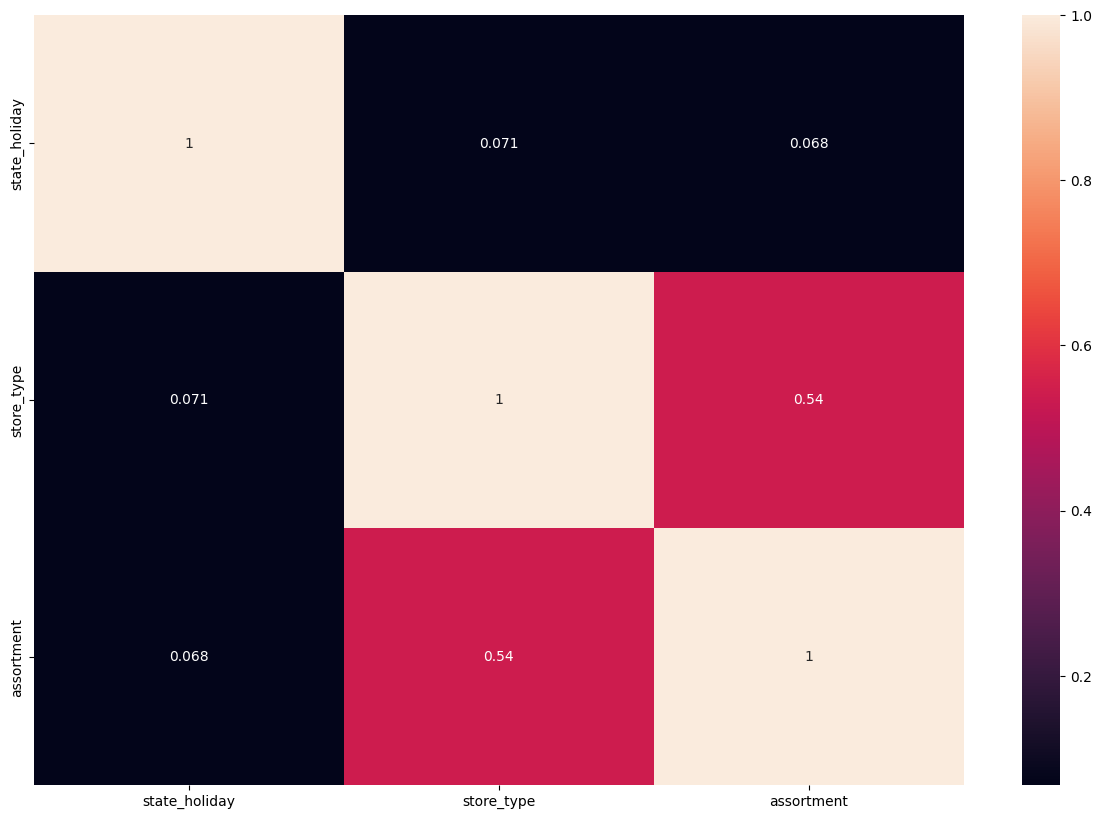

In [66]:
plt.figure(figsize = (15, 10))
sns.heatmap(d, annot = True);

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [67]:
df5 = df4.copy()

## 5.1 Variáveis numéricas

### 5.1.1 Padronização

In [68]:
#Este tipo de transformação de variáveis são indicadas para distribuições normais
#Verificar na análise univariada quais variáveis tem esta caracteristica de distribuição normal

In [69]:
#Como na análise univariada não foi identificada variáveis com distribuição
#normal, os dados não serão padronizados e sim normalizados

### 5.1.2 Normalização

In [70]:
#Este tipo de transformação de variáveis são indicadas para distribuições não normais

In [71]:
#Selecionando as variáveis numéricas
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


In [72]:
#'competition_distance'
#'competition_time_month'
#'promo_time_week'
#'year'

In [73]:
#Verificando se as variáveis tem outliers para que seja escolhido
#o método RobustScaler, ou se será escolhido o método MinMaxScaler

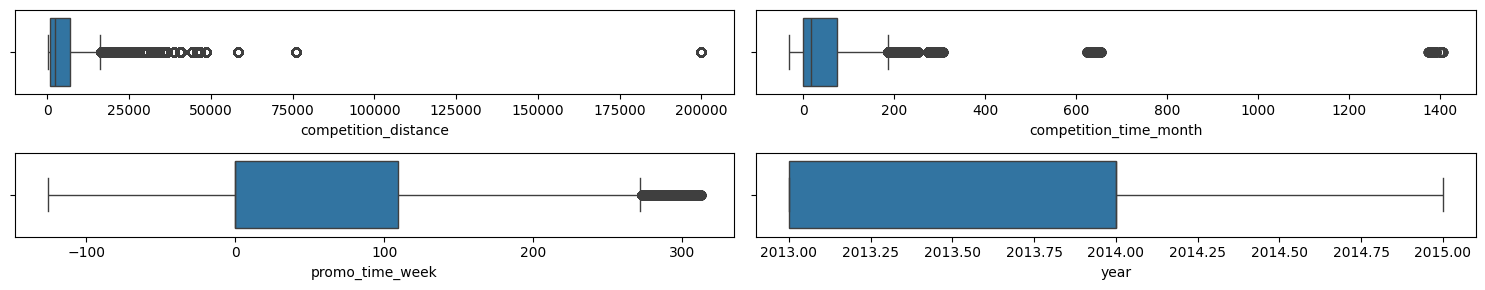

In [74]:
plt.figure(figsize = (15,3))

plt.subplot(2, 2, 1)
sns.boxplot(df5['competition_distance'], orient = 'h');

plt.subplot(2, 2, 2)
sns.boxplot(df5['competition_time_month'], orient = 'h');

plt.subplot(2, 2, 3)
sns.boxplot(df5['promo_time_week'], orient = 'h');

plt.subplot(2, 2, 4)
sns.boxplot(df5['year'], orient = 'h');
plt.tight_layout();

In [75]:
rs = RobustScaler()
mms = MinMaxScaler()

#'competition_distance'
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#'competition_time_month'
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#'promo_time_week'
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#'year'
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.2 Variáveis categóricas

### 5.2.1 Transformação

##### 5.2.1.1 Encoding

In [76]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [77]:
#Selecionando as variáveis categóricas
#'state_holiday' -> One Hot Enconding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#'store_type' -> Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#'assortment' -> Ordinal Enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [78]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter holiday,state_holiday_public holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True


##### 5.2.1.2 Transformação de grandeza da variável resposta

In [79]:
#O objetivo da transformação de grandeza da variável resposta é trazer ela mais próxima possivel da distribuição
#normal, pois como as demais variáveis foram transformadas, a variável resposta também precisa estar na mesma escala 

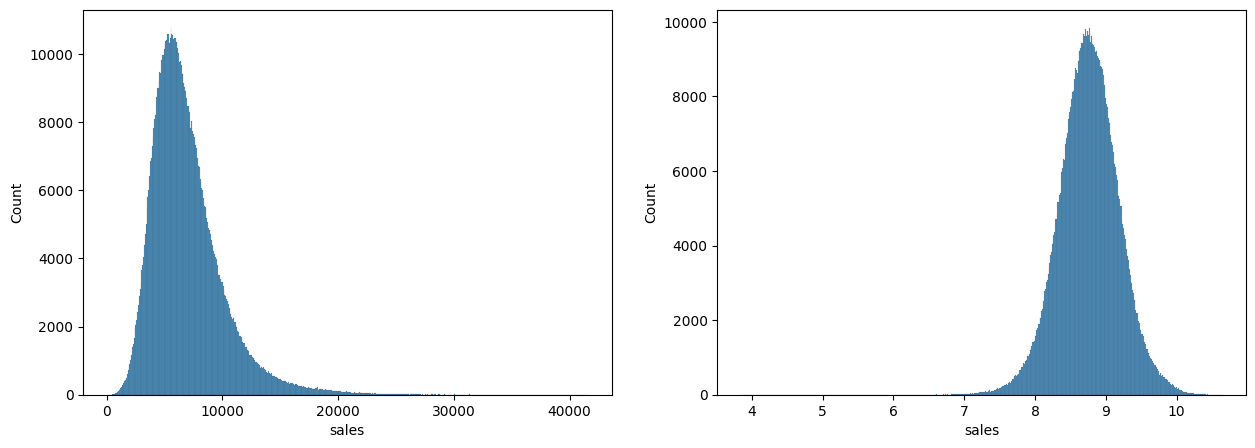

In [80]:
plt.figure(figsize = (15,5))

plt.subplot(1, 2, 1)
sns.histplot(df4['sales']);

plt.subplot(1, 2, 2)
df5['sales'] = np.log1p(df5['sales'])
sns.histplot(x ='sales', data = df5);

##### 5.2.1.3 Transformação de natureza (transformação cíclica)

In [81]:
#Estas variáveis abaixo tem uma natureza cíclica, ou seja, mês por exemplo, vai de 1 ao 12 e depois começa de novo! 
#'day_of_week'
periodo_ciclico = 7
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#'month'
periodo_ciclico = 12
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#'day'
periodo_ciclico = 30
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#'week_of_year'
periodo_ciclico = 52
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

In [82]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis mais relevantes

In [83]:
df6 = df5.copy()

### 6.1 Separação dos dados em treino e teste

In [84]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [85]:
#Deletar as variáveis originais que tiveram as colunas que foram criadas
#a partir delas, pois quanto mais colunas mais complexo fica o modelo
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [86]:
#Encontrando a maior data do dataframe e subtraindo 6 semanas (6*7) para que este conjunto
#de dados seja utilizado como treino e as datas porteriores sejam utlizados como teste   
limite_data_treino = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)

#Dataset de treino
x_treino = df6[df6['date'] < limite_data_treino]
y_treino = x_treino['sales']

#Dataset de teste
x_teste = df6[df6['date'] >= limite_data_treino]
y_teste = x_teste['sales']

In [87]:
print('Treino min data: {}'.format(x_treino['date'].min()))
print('Treino max data: {}'.format(x_treino['date'].max()))
print('\nTeste min data: {}'.format(x_teste['date'].min()))
print('Teste max data: {}'.format(x_teste['date'].max()))

Treino min data: 2013-01-01 00:00:00
Treino max data: 2015-06-18 00:00:00

Teste min data: 2015-06-19 00:00:00
Teste max data: 2015-07-31 00:00:00


### 6.2 Implementando o algoritmo Boruta

In [88]:
#Retirando as colunas 'date' e 'sales'
#x_treino_drop = x_treino.drop(['date', 'sales'], axis = 1).values
#y_treino_drop = y_treino.values.ravel()
#Instanciando o algoritmo de Random Forest
#rf = RandomForestRegressor(n_jobs = -1)
#Boruta espera receber um vetor e não dataframe
#boruta = BorutaPy(rf, n_estimators = 2, verbose = 2, random_state = 42).fit(x_treino_drop, y_treino_drop)

#### 6.2.1 Melhores variáveis selecionadas pelo Boruta

In [89]:
#cols_selected = boruta.support_.tolist()

#x_treino_aux = x_treino.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = x_treino_aux.iloc[:, cols_selected].columns.to_list()

#Variáveis não selecionadas pelo Boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_treino_aux.columns, cols_selected_boruta))

#### 6.2.2 Seleção manual das variáveis

In [90]:
#Avaliar se as variáveis que o algoritmo Boruta selecionou são as mesmas
#variáveis relevantes que foram identificadas na análise bivariada
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

In [91]:
cols_not_selected_boruta = ['is_promo',
                            'month_sin',
                            'school_holiday',
                            'state_holiday_christmas',
                            'state_holiday_easter_holiday',
                            'state_holiday_puplic_holiday',
                            'state_holiday_regular_day',
                            'week_of_year_sin',
                            'year']

In [92]:
#Adicionando novamente as colunas 'date' e 'sales' no dataframe
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7. (Algoritmos de ML) Passo 7: Implementando os modelos de machine learning

In [93]:
#Esta variável será utilizada mais a frente
x_treino_aux1 = x_treino.copy()
x_teste_aux1 = x_teste.copy()

#Neste momento das colunas 'date' e 'sales' não serão utilizadas
x_treino = x_treino[cols_selected_boruta]
x_teste = x_teste[cols_selected_boruta]

x_treinamento = x_treino_aux1[cols_selected_boruta_full]

### 7.1 Algoritmo de média

In [94]:
aux1 = x_teste.copy()
aux1['sales'] = y_teste.copy()

#Previsão
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left',  on = 'store')
y_pred_baseline = aux1['predictions']

#Performance
#Utilizando a função np.expm1 (inverso da np.log1p) para trazer os dados na escala original
baseline_resultado = ml_error('algoritmo_de_media', np.expm1(y_teste), np.expm1(y_pred_baseline))
baseline_resultado

,nome_algoritmo,mae,mape,rmse
0,algoritmo_de_media,1354.800353,0.455051,1835.135542


### 7.2 Algoritmo de regressão linear

In [95]:
#Previsão
lr = LinearRegression().fit(x_treino, y_treino)
y_pred_lr = lr.predict(x_teste)

#Performance
#Utilizando a função np.expm1 (inverso da np.log1p) para trazer os dados na escala original
resultado_lr = ml_error('algoritmo_de_regressao_linear', np.expm1(y_teste), np.expm1(y_pred_lr))
resultado_lr

,nome_algoritmo,mae,mape,rmse
0,algoritmo_de_regressao_linear,1867.089774,0.292694,2671.049215


#### 7.2.1 Algoritmo de regressão linear com cross validation

In [96]:
#cross_validation(x_treinanento, kfold, model_name, model, verbose = False):
resultado_lr_cv = cross_validation(x_treinamento, 5, 'algoritmo_de_regressao_linear', lr, verbose = False)
resultado_lr_cv

,algoritmo,mae_cv,mape_cv,rmse_cv
0,algoritmo_de_regressao_linear,2081.73 +/-295.63,0.3 +/-0.02,2952.52 +/-468.37


### 7.3 Algoritmo de regressão linear regularizada - Lasso

In [97]:
#Previsão
lrr = Lasso(alpha = 0.01).fit(x_treino, y_treino)
y_pred_lrr = lrr.predict(x_teste)

#Performance
#Utilizando a função np.expm1 (inverso da np.log1p) para trazer os dados na escala original
resultado_lrr = ml_error('algoritmo_de_regressao_linear_lasso', np.expm1(y_teste), np.expm1(y_pred_lrr))
resultado_lrr

,nome_algoritmo,mae,mape,rmse
0,algoritmo_de_regressao_linear_lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Algoritmo de regressão linear relularizada - Lasso com cross validation

In [98]:
#cross_validation(x_treinanento, kfold, model_name, model, verbose = False):
resultado_lrr_cv = cross_validation(x_treinamento, 5, 'algoritmo_de_regressao_linear_lasso', lrr, verbose = False)
resultado_lrr_cv

,algoritmo,mae_cv,mape_cv,rmse_cv
0,algoritmo_de_regressao_linear_lasso,2116.38 +/-341.5,0.29 +/-0.01,3057.75 +/-504.26


### 7.4 Algoritmo de random forest

In [99]:
#Previsão
rf = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42).fit(x_treino, y_treino)
y_pred_rf = rf.predict(x_teste)

#Performance
#Utilizando a função np.expm1 (inverso da np.log1p) para trazer os dados na escala original
resultado_rf = ml_error('algoritmo_random_forest', np.expm1(y_teste), np.expm1(y_pred_rf))
resultado_rf

,nome_algoritmo,mae,mape,rmse
0,algoritmo_random_forest,722.698084,0.106205,1073.967084


#### 7.4.1 Algoritmo de random forest com cross validation

In [100]:
#cross_validation(x_treinanento, kfold, model_name, model, verbose = False):
resultado_rf_cv = cross_validation(x_treinamento, 5, 'algoritmo_random_forest', rf, verbose = False)
resultado_rf_cv

,algoritmo,mae_cv,mape_cv,rmse_cv
0,algoritmo_random_forest,887.55 +/-232.49,0.12 +/-0.02,1328.39 +/-340.35


### 7.5 Algoritmo de xgboost

In [101]:
#Previsão
modelo_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                              n_estimators = 10,
                              eta = 0.01,
                              max_depth = 10,
                              subsample = 0.7,
                              colsample_bytree = 0.9)

modelo_xgb.fit(x_treino, y_treino)
y_pred_xgb = modelo_xgb.predict(x_teste)

#Performance
#Utilizando a função np.expm1 (inverso da no.log1p) para trazer os dados na escala original
resultado_xgb = ml_error('algoritmo_xgboost', np.expm1(y_teste), np.expm1(y_pred_xgb))
resultado_xgb

,nome_algoritmo,mae,mape,rmse
0,algoritmo_xgboost,2113.937506,0.326571,3009.596362


#### 7.5.1 Algoritmo de xgboost com cross validation

In [102]:
#cross_validation(x_treinanento, kfold, model_name, model, verbose = False):
resultado_xgb_cv = cross_validation(x_treinamento, 5, 'algoritmo_xgboost', modelo_xgb, verbose = False)
resultado_xgb_cv

,algoritmo,mae_cv,mape_cv,rmse_cv
0,algoritmo_xgboost,2302.43 +/-385.62,0.32 +/-0.01,3264.71 +/-554.42


### 7.6 Comparando os modelos

#### 7.6.1 Sem cross validation

In [103]:
resultado = pd.concat([baseline_resultado, resultado_lr, resultado_lrr, resultado_rf, resultado_xgb])
resultado.sort_values('rmse').reset_index(drop = True)

,nome_algoritmo,mae,mape,rmse
0,algoritmo_random_forest,722.698084,0.106205,1073.967084
1,algoritmo_de_media,1354.800353,0.455051,1835.135542
2,algoritmo_de_regressao_linear,1867.089774,0.292694,2671.049215
3,algoritmo_de_regressao_linear_lasso,1891.704881,0.289106,2744.451737
4,algoritmo_xgboost,2113.937506,0.326571,3009.596362


#### 7.6.2 Com cross validation - Performance real

In [104]:
resultado_cv = pd.concat([resultado_lr_cv, resultado_lrr_cv, resultado_rf_cv, resultado_xgb_cv])
resultado_cv.sort_values('rmse_cv').reset_index(drop = True)

,algoritmo,mae_cv,mape_cv,rmse_cv
0,algoritmo_random_forest,887.55 +/-232.49,0.12 +/-0.02,1328.39 +/-340.35
1,algoritmo_de_regressao_linear,2081.73 +/-295.63,0.3 +/-0.02,2952.52 +/-468.37
2,algoritmo_de_regressao_linear_lasso,2116.38 +/-341.5,0.29 +/-0.01,3057.75 +/-504.26
3,algoritmo_xgboost,2302.43 +/-385.62,0.32 +/-0.01,3264.71 +/-554.42


# 8. (Algoritmos de Ml) Passo 8: Ajuste dos hiperparâmetros no algoritmo

### 8.1 Random search

In [105]:
#Encontrando os melhores parâmetros 
#parametros = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#              'eta': [0.01, 0.03],
#              'max_depth': [3, 5, 9],
#              'subsample': [0.1, 0.5, 0.7],
#              'colsample_bytree': [0.3, 0.7, 0.9],
#              'min_child_weight': [3, 8, 15]}

#MAX_EVAL = 4 #Nº de iterações

#resultado_final = pd.DataFrame()

#for i in range(MAX_EVAL):
#    hp = {k: random.sample(v, 1)[0] for k, v in parametros.items()}
#    print(hp)
    #Previsão
#    modelo_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                  n_estimators = hp['n_estimators'],
#                                  eta = hp['eta'],
#                                  max_depth = hp['max_depth'],
#                                  subsample = hp['subsample'],
#                                  colsample_bytree = hp['colsample_bytree'],
#                                  min_child_weight = hp['min_child_weight'])
    #Performance
#    resultado_xgb = cross_validation(x_treinamento, 2, 'algoritmo_xgboost', modelo_xgb, verbose = False)
#    resultado_final = pd.concat([resultado_final, resultado_xgb])
    
#resultado_final

### 8.2 Modelo final

In [106]:
#Rodar movamente o algoritmo escolhido com os melhores parâmetros
parametros_ajustados = {'n_estimators': 15,
                        'eta': 0.03,
                        'max_depth': 9,
                        'subsample': 0.7,
                        'colsample_bytree': 0.7,
                        'min_child_weight': 15}

modelo_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                              n_estimators = parametros_ajustados['n_estimators'],
                              eta = parametros_ajustados['eta'],
                              max_depth = parametros_ajustados['max_depth'],
                              subsample = parametros_ajustados['subsample'],
                              colsample_bytree = parametros_ajustados['colsample_bytree'],
                              min_child_weight = parametros_ajustados['min_child_weight']).fit(x_treino, y_treino)

#Previsão
y_pred_xgb = modelo_xgb.predict(x_teste)

#Performance
resultado_xgb = ml_error('algoritmo_xgboost', np.expm1(y_teste), np.expm1(y_pred_xgb))
resultado_xgb

,nome_algoritmo,mae,mape,rmse
0,algoritmo_xgboost,1929.98835,0.292959,2789.100068


In [107]:
#O mpe é calculado por último para avaliar se o modelo está superestimando (valor negativo) ou 
#subestimando (valor positivo) e com isso reportar ao time de negócio para que eles tomem as decisões
mean_percentage_error(np.expm1(y_teste), np.expm1(y_pred_xgb))

-0.05648987968531165

# 9. (Avaliação dos algoritmos) Passo 9: Tradução e interpretação do erro

In [108]:
df9 = x_teste_aux1[cols_selected_boruta_full]

#Reescalar
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(y_pred_xgb)

### 9.1 Performance do negócio

In [109]:
#Somar as predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#Utilizar o MAE e o MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'mae'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'mape'})

#Juntando os dataframes
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

#Criando cenários
df92['pior_cenario'] = df92['predictions'] - df92['mae']
df92['melhor_cenario'] = df92['predictions'] + df92['mae']

#Ordenando as colunas
df92 = df92[['store', 'predictions', 'melhor_cenario', 'pior_cenario', 'mae', 'mape']]

In [110]:
df92.sort_values('mape', ascending = False).head()

,store,predictions,melhor_cenario,pior_cenario,mae,mape
542,543,229335.859375,232886.990577,225784.728173,3551.131202,1.675533
306,307,220926.171875,224254.825354,217597.518396,3328.653479,1.504884
969,970,216636.765625,219711.056482,213562.474768,3074.290857,1.433714
840,841,201610.265625,204530.894281,198689.636969,2920.628656,1.293785
197,198,191575.000000,193970.567726,189179.432274,2395.567726,1.270615


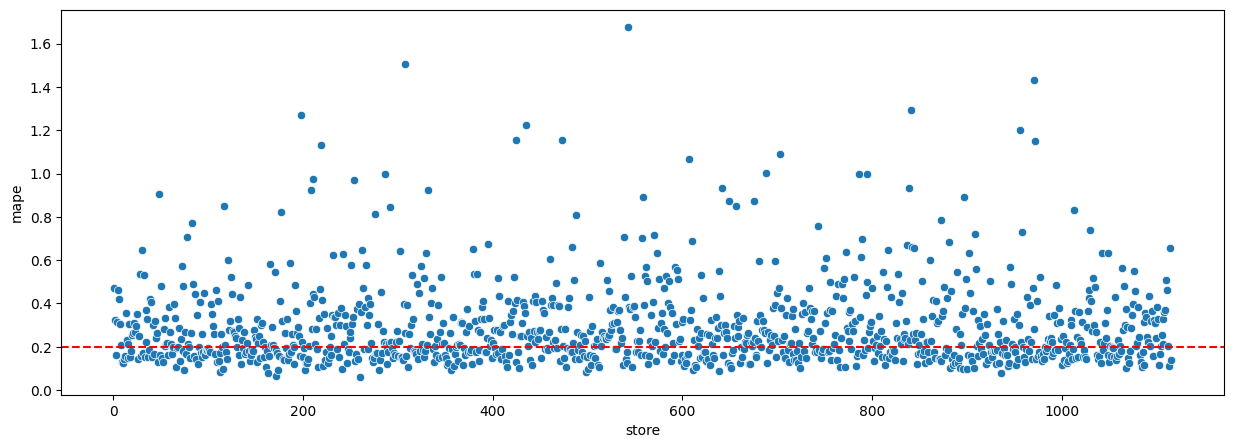

In [111]:
plt.figure(figsize = (15, 5))
sns.scatterplot(x = 'store', y = 'mape', data = df92)
plt.axhline(y = 0.2, color = 'red', linestyle = '--');

### 9.2 Performance total

In [112]:
df93 = df92[['predictions', 'melhor_cenario', 'pior_cenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'cenario', 0: 'soma'})
df93['soma'] = df93['soma'].map('R${:,.2f}'.format)
df93

,cenario,soma
0,predictions,"R$263,766,784.00"
1,melhor_cenario,"R$265,916,977.16"
2,pior_cenario,"R$261,616,587.40"


### 9.3 Performance do algoritmo

In [113]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

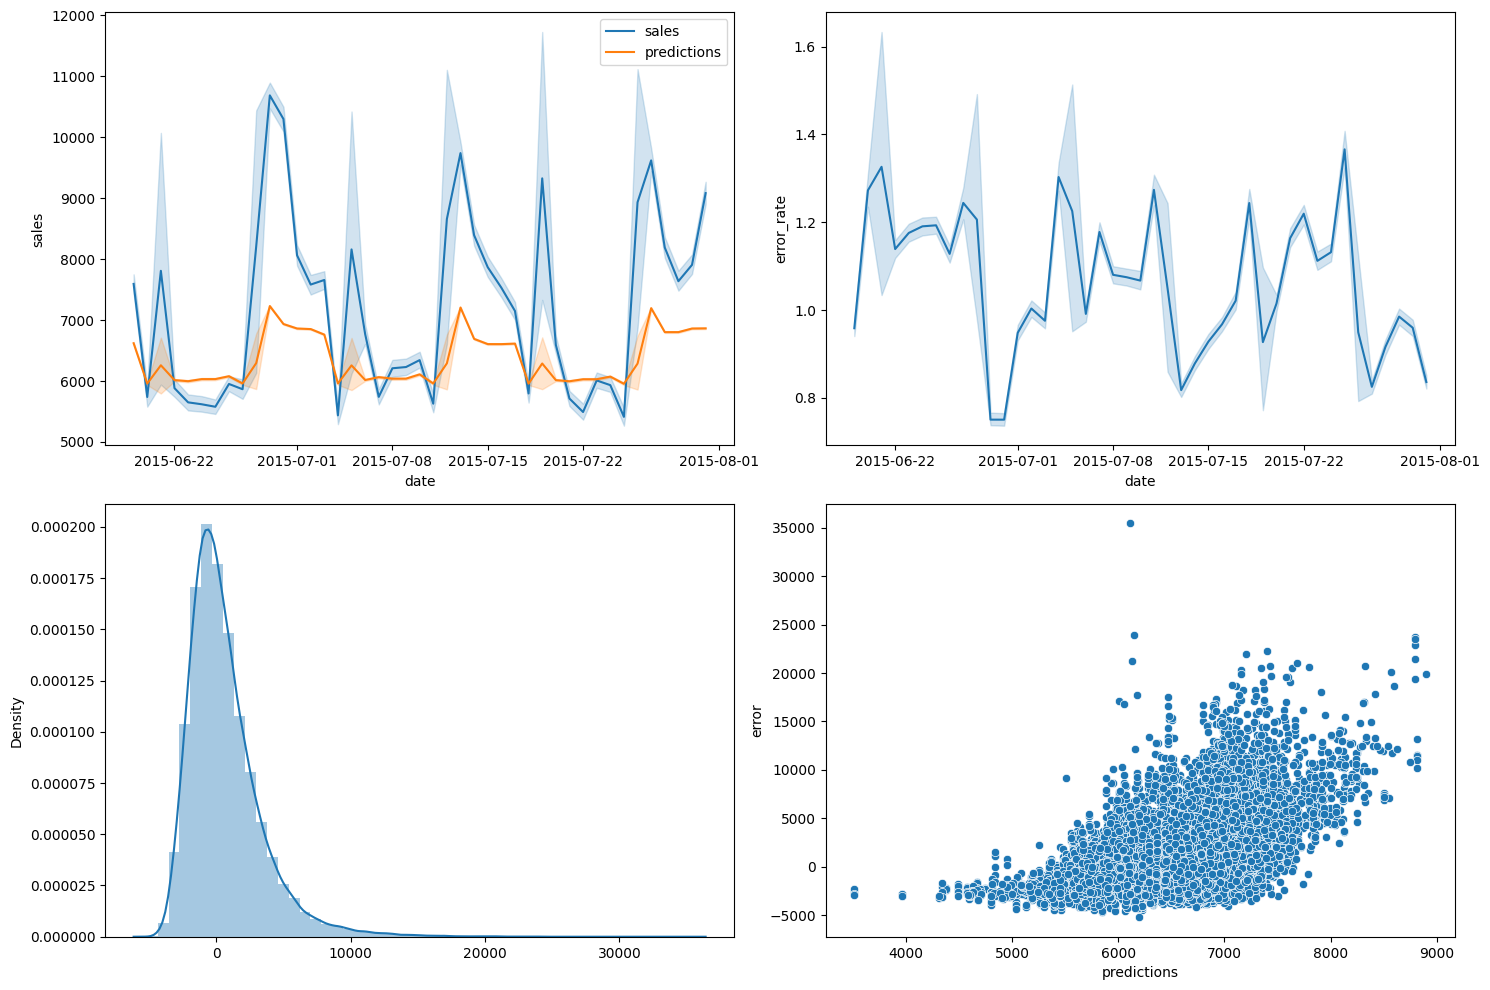

In [114]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'predictions')
plt.tight_layout();

plt.subplot(2, 2, 2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.tight_layout();

plt.subplot(2, 2, 3)
sns.distplot(x = df9['error'])
plt.tight_layout();

plt.subplot(2, 2, 4)
sns.scatterplot(x = 'predictions', y = 'error', data = df9)
plt.tight_layout();

# 10. (Modelo em produção) Passo 10: Modelo em produção

In [115]:
#Salvando todas as transformações executadas nos dados e também o algoritmo escolhido
#Salvando o modelo treinado
pickle.dump(modelo_xgb, open('/home/leonardo/projetos_/api/modelo/Rossmann.pkl', 'wb'))

#Salvando a normalização do modelo treinado
pickle.dump(rs, open('/home/leonardo/projetos_/api/parametros/competition_distance_scaler.pkl', 'wb'))

#Salvando a normalização do modelo treinado
pickle.dump(rs, open('/home/leonardo/projetos_/api/parametros/competition_time_month_scaler.pkl', 'wb'))

#Salvando a normalização do modelo treinado
pickle.dump(rs, open('/home/leonardo/projetos_/api/parametros/promo_time_week_scaler.pkl', 'wb'))

#Salvando a normalização do modelo treinado
pickle.dump(le, open('/home/leonardo/projetos_/api/parametros/store_type_scaler.pkl', 'wb'))

#Salvando a normalização do modelo treinado
pickle.dump(mms, open('/home/leonardo/projetos_/api/parametros/year_scaler.pkl', 'wb'))

### 10.1 Criando a classe Rossmann

In [116]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

#Aplicando as limpezas, transformações, encoding e predição do modelo
class Rossmann(object):
    def __init__(self):
        #Lendo o arquivo
        self.home_path = '/home/leonardo/projetos_/api/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parametros/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parametros/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parametros/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parametros/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parametros/store_type_scaler.pkl', 'rb'))

    def limpeza_dos_dados(self, df1):
        #Renomeando as colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))        
        df1.columns = cols_new
        #Convertendo a coluna 'date' para date mesmo
        df1['date'] = pd.to_datetime(df1['date'])
        
        #Preenchendo as colunas com NA's
        #competition_distance
        #Inserindo um valor muito maior que o máximo valor da coluna 
        df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000 if math.isnan(x) else x)
        
        #competition_open_since_month
        #Como não tem data, está sendo assumido o valor da coluna data para preencher este campo
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)
        
        #Verificando os tipos novamente devido a alteração das colunas com NA's
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)    
        
        return df1

    def engenharia_de_atributos(self, df2):
        #Derivando as variáveis a partir das variáveis originais
        #year
        df2['year'] = df2['date'].dt.year
        
        #month
        df2['month'] = df2['date'].dt.month
       
        #day
        df2['day'] = df2['date'].dt.day
        
        #week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        
        #week of week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int) 
        
        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int) 
        
        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public holiday' if x == 'a' else 'easter holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        #Na coluna 'open', para a predição é necessário as lojas estejam abertas para prever a qtde de vendas nas próximas 6 semanas
        #'open' != 0
        #Outra restrição do negócio
        #'sales' > 0
        df2 = df2[df2['open'] != 0]
        
        #Na coluna 'customers', não tenho como saber quantos clientes terão daqui 6 semanas então se torna uma restrição do negócio
        #'customers'
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2      

    def preparacao_dos_dados(self, df5):
        #Aplicando a normalização
        #'competition_distance'
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        #'competition_time_month'
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        #'promo_time_week'
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        #'year'
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        #Selecionando as variáveis categóricas
        #'state_holiday' -> One Hot Enconding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])
        
        #'store_type' -> Label Enconding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        #'assortment' -> Ordinal Enconding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        #Estas variáveis abaixo tem uma natureza cíclica, ou seja, mês por exemplo, vai de 1 ao 12 e depois começa de novo! 
        #'day_of_week'
        periodo_ciclico = 7
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))
        
        #'month'
        periodo_ciclico = 12
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))
        
        #'day'
        periodo_ciclico = 30
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))
        
        #'week_of_year'
        periodo_ciclico = 52
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                        'competition_open_since_month', 'competition_open_since_year', 'promo2',
                        'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                        'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                        'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[cols_selected]

    def get_prediction(self, modelo, original_data, teste_data):
        #Predição
        pred = modelo.predict(teste_data)

        #Juntando a predição com os dados originais
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient = 'records', date_format = 'iso')

### 10.2 Criando a API Handler

In [117]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#Importando classe Rossmann do arquivo Rossmann.py da pasta rossmann
#from nome_pasta ou diretório.nome_arquivo import nome da classe dentro do arquivo
from rossmann.Rossmann import Rossmann 

#Carregando o modelo
modelo = pickle.load(open('/home/leonardo/projetos_/api/modelo/Rossmann.pkl', 'rb'))

#Instaciando objeto da classe Flask que será a API
app = Flask(__name__)

#Método POST envia alguma coisa
#Método GET pede alguma coisa
@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    teste_json = request.get_json()
    
    if teste_json:
        if isinstance(teste_json, dict):
            teste_raw = pd.DataFrame(teste_json, index = [0])
        else:
            teste_raw = pd.DataFrame(teste_json, columns = teste_json[0].keys())
        #Instanciando a classe Rossmann
        pipeline = Rossmann()

        #limpeza_dos_dados
        df1 = pipeline.limpeza_dos_dados(teste_raw)
        
        #engenharia_de_atributos
        df2 = pipeline.engenharia_de_atributos(df1)
        
        #preparacao_dos_dados
        df3 = pipeline.preparacao_dos_dados(df2)
        
        #predição
        df_resposta = pipeline.get_prediction(modelo, teste_raw, df3)
        
        return df_resposta
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run('0.0.0.0') #Dizer para endpoint rodar no localhost (rodando na máquina)
#172.25.114.131 -> endereço IPv4 pc local
#app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

### 10.3 Testando a API

In [ ]:
import requests

#Carregando os dados para teste
df10 = pd.read_csv('/home/leonardo/projetos_/dataset/test.csv')

In [ ]:
#Juntando os dados de test + dados do store
df_teste = pd.merge(df10, df_store_raw, how = 'left', on = 'Store')

#Escolhendo uma loja qualquer para a predição
df_teste = df_teste[df_teste['Store'].isin([24, 12, 22])]

#Removendo os dias de loja fechado
df_teste = df_teste[df_teste['Open'] != 0]
df_teste = df_teste[~df_teste['Open'].isnull()]
df_teste = df_teste.drop('Id', axis = 1)

In [ ]:
#Convertendo o dataframe em formato JSON
import json
data = json.dumps(df_teste.to_dict(orient = 'records'))

In [ ]:
#Chamando a API
url = 'https://projeto-rossmann-sj4u.onrender.com/rossmann/predict' #Este é o novo endereço a partir da nuvem
#url = 'http://0.0.0.0:5000/rossmann/predict' #Endpoint -> 0.0.0.0 é a máquina local e :5000 é a porta padrão da biblioteca flask
header = {'Content-type': 'application/json'} #Indica para o API qual tipo de dado ele está recebendo
data = data #Dados
r = requests.post(url, data, headers = header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Loja nº {} irá vender R${:,.2f} nas próximas 6 semanas'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']) )